In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
!kaggle datasets download -d imetomi/eur-usd-forex-pair-historical-data-2002-2019

 85% 89.0M/105M [00:02<00:00, 24.0MB/s]
100% 105M/105M [00:02<00:00, 38.4MB/s] 


In [ ]:
!ls

 base.model					    kaggle.json  'Old data'
 eur-usd-forex-pair-historical-data-2002-2019.zip   logs


In [ ]:
!unzip \*.zip  && rm *.zip

Archive:  eur-usd-forex-pair-historical-data-2002-2019.zip
  inflating: eurusd_hour.csv         
  inflating: eurusd_minute.csv       
  inflating: eurusd_news.csv         


In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

In [ ]:
data = pd.read_csv('eurusd_hour.csv')
data

,Date,Hour,BidOpen,BidHigh,BidLow,BidClose,BidChange,AskOpen,AskHigh,AskLow,AskClose,AskChange
0,2002-05-05,19:00,0.91680,0.91680,0.91680,0.91680,0.00000,0.91780,0.91780,0.91780,0.91780,0.00000
1,2002-05-06,20:00,0.91810,0.91810,0.91810,0.91810,0.00000,0.91840,0.91840,0.91840,0.91840,0.00000
2,2002-05-07,20:00,0.91520,0.91520,0.91520,0.91520,0.00000,0.91550,0.91550,0.91550,0.91550,0.00000
3,2002-05-08,20:00,0.90420,0.90420,0.90420,0.90420,0.00000,0.90450,0.90450,0.90450,0.90450,0.00000
4,2002-05-09,20:00,0.90920,0.90920,0.90920,0.90920,0.00000,0.90950,0.90950,0.90950,0.90950,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
90227,2019-01-18,19:00,1.13651,1.13714,1.13627,1.13696,-0.00045,1.13663,1.13727,1.13641,1.13708,-0.00045
90228,2019-01-18,20:00,1.13695,1.13695,1.13615,1.13647,0.00048,1.13709,1.13709,1.13628,1.13661,0.00048
90229,2019-01-18,21:00,1.13646,1.13654,1.13573,1.13589,0.00057,1.13660,1.13698,1.13644,1.13666,-0.00006
90230,2019-01-20,22:00,1.13565,1.13667,1.13565,1.13652,-0.00087,1.13665,1.13716,1.13632,1.13678,-0.00013


In [ ]:
# Merge date and hour coloumn into one coloumn called datetime
data['datetime'] = data['Date'] + " " + data['Hour']
data = data.drop(columns=['Date', 'Hour'])
data

,BidOpen,BidHigh,BidLow,BidClose,BidChange,AskOpen,AskHigh,AskLow,AskClose,AskChange,datetime
0,0.91680,0.91680,0.91680,0.91680,0.00000,0.91780,0.91780,0.91780,0.91780,0.00000,2002-05-05 19:00
1,0.91810,0.91810,0.91810,0.91810,0.00000,0.91840,0.91840,0.91840,0.91840,0.00000,2002-05-06 20:00
2,0.91520,0.91520,0.91520,0.91520,0.00000,0.91550,0.91550,0.91550,0.91550,0.00000,2002-05-07 20:00
3,0.90420,0.90420,0.90420,0.90420,0.00000,0.90450,0.90450,0.90450,0.90450,0.00000,2002-05-08 20:00
4,0.90920,0.90920,0.90920,0.90920,0.00000,0.90950,0.90950,0.90950,0.90950,0.00000,2002-05-09 20:00
...,...,...,...,...,...,...,...,...,...,...,...
90227,1.13651,1.13714,1.13627,1.13696,-0.00045,1.13663,1.13727,1.13641,1.13708,-0.00045,2019-01-18 19:00
90228,1.13695,1.13695,1.13615,1.13647,0.00048,1.13709,1.13709,1.13628,1.13661,0.00048,2019-01-18 20:00
90229,1.13646,1.13654,1.13573,1.13589,0.00057,1.13660,1.13698,1.13644,1.13666,-0.00006,2019-01-18 21:00
90230,1.13565,1.13667,1.13565,1.13652,-0.00087,1.13665,1.13716,1.13632,1.13678,-0.00013,2019-01-20 22:00


In [ ]:
# make datetime become index
data['datetime'] = pd.to_datetime(data['datetime'])
data.index = pd.to_datetime(data['datetime'])
data = data.drop(columns=['datetime'])
data

,BidOpen,BidHigh,BidLow,BidClose,BidChange,AskOpen,AskHigh,AskLow,AskClose,AskChange
datetime,,,,,,,,,,
2002-05-05 19:00:00,0.91680,0.91680,0.91680,0.91680,0.00000,0.91780,0.91780,0.91780,0.91780,0.00000
2002-05-06 20:00:00,0.91810,0.91810,0.91810,0.91810,0.00000,0.91840,0.91840,0.91840,0.91840,0.00000
2002-05-07 20:00:00,0.91520,0.91520,0.91520,0.91520,0.00000,0.91550,0.91550,0.91550,0.91550,0.00000
2002-05-08 20:00:00,0.90420,0.90420,0.90420,0.90420,0.00000,0.90450,0.90450,0.90450,0.90450,0.00000
2002-05-09 20:00:00,0.90920,0.90920,0.90920,0.90920,0.00000,0.90950,0.90950,0.90950,0.90950,0.00000
...,...,...,...,...,...,...,...,...,...,...
2019-01-18 19:00:00,1.13651,1.13714,1.13627,1.13696,-0.00045,1.13663,1.13727,1.13641,1.13708,-0.00045
2019-01-18 20:00:00,1.13695,1.13695,1.13615,1.13647,0.00048,1.13709,1.13709,1.13628,1.13661,0.00048
2019-01-18 21:00:00,1.13646,1.13654,1.13573,1.13589,0.00057,1.13660,1.13698,1.13644,1.13666,-0.00006


In [ ]:
# convert hourly data to daily data with take the average/mean value in a day
data = data.resample('D').mean()
data

,BidOpen,BidHigh,BidLow,BidClose,BidChange,AskOpen,AskHigh,AskLow,AskClose,AskChange
datetime,,,,,,,,,,
2002-05-05,0.916800,0.916800,0.916800,0.916800,0.000000,0.917800,0.917800,0.917800,0.917800,0.000000
2002-05-06,0.918100,0.918100,0.918100,0.918100,0.000000,0.918400,0.918400,0.918400,0.918400,0.000000
2002-05-07,0.915200,0.915200,0.915200,0.915200,0.000000,0.915500,0.915500,0.915500,0.915500,0.000000
2002-05-08,0.904200,0.904200,0.904200,0.904200,0.000000,0.904500,0.904500,0.904500,0.904500,0.000000
2002-05-09,0.909200,0.909200,0.909200,0.909200,0.000000,0.909500,0.909500,0.909500,0.909500,0.000000
...,...,...,...,...,...,...,...,...,...,...
2019-01-16,1.139982,1.140698,1.139385,1.139913,0.000069,1.140132,1.140853,1.139544,1.140057,0.000075
2019-01-17,1.139018,1.139561,1.138418,1.138987,0.000030,1.139164,1.139716,1.138587,1.139128,0.000035
2019-01-18,1.138613,1.139065,1.138049,1.138464,0.000149,1.138750,1.139216,1.138214,1.138627,0.000122


In [ ]:
# checking whether there is null value or not and yeah there are so many missing value
data.isnull().sum()

BidOpen      900
BidHigh      900
BidLow       900
BidClose     900
BidChange    900
AskOpen      900
AskHigh      900
AskLow       900
AskClose     900
AskChange    900
dtype: int64

In [ ]:
# filling NaN value with mean of its row
for x in range(10):
  data.iloc[:,x].fillna(data.iloc[:,x].mean(), inplace = True)
  data.iloc[:,x]
data

,BidOpen,BidHigh,BidLow,BidClose,BidChange,AskOpen,AskHigh,AskLow,AskClose,AskChange
datetime,,,,,,,,,,
2002-05-05,0.916800,0.916800,0.916800,0.916800,0.000000,0.917800,0.917800,0.917800,0.917800,0.000000
2002-05-06,0.918100,0.918100,0.918100,0.918100,0.000000,0.918400,0.918400,0.918400,0.918400,0.000000
2002-05-07,0.915200,0.915200,0.915200,0.915200,0.000000,0.915500,0.915500,0.915500,0.915500,0.000000
2002-05-08,0.904200,0.904200,0.904200,0.904200,0.000000,0.904500,0.904500,0.904500,0.904500,0.000000
2002-05-09,0.909200,0.909200,0.909200,0.909200,0.000000,0.909500,0.909500,0.909500,0.909500,0.000000
...,...,...,...,...,...,...,...,...,...,...
2019-01-16,1.139982,1.140698,1.139385,1.139913,0.000069,1.140132,1.140853,1.139544,1.140057,0.000075
2019-01-17,1.139018,1.139561,1.138418,1.138987,0.000030,1.139164,1.139716,1.138587,1.139128,0.000035
2019-01-18,1.138613,1.139065,1.138049,1.138464,0.000149,1.138750,1.139216,1.138214,1.138627,0.000122


In [ ]:
data.isnull().sum()

BidOpen      0
BidHigh      0
BidLow       0
BidClose     0
BidChange    0
AskOpen      0
AskHigh      0
AskLow       0
AskClose     0
AskChange    0
dtype: int64

In [ ]:
data.describe()

,BidOpen,BidHigh,BidLow,BidClose,BidChange,AskOpen,AskHigh,AskLow,AskClose,AskChange
count,6105.000000,6105.000000,6105.000000,6105.000000,6105.000000,6105.000000,6105.000000,6105.000000,6105.000000,6105.000000
mean,1.257786,1.258633,1.256966,1.257792,-0.000006,1.258077,1.258915,1.257247,1.258068,0.000009
std,0.121065,0.121280,0.120848,0.121064,0.000309,0.121044,0.121259,0.120827,0.121048,0.000310
min,0.902600,0.902600,0.902600,0.902600,-0.002693,0.902900,0.902900,0.902900,0.902900,-0.002621
25%,1.178097,1.178627,1.177561,1.178143,-0.000113,1.178400,1.178852,1.177718,1.178500,-0.000100
50%,1.257786,1.258633,1.256966,1.257792,-0.000006,1.258077,1.258915,1.257247,1.258068,0.000009
75%,1.334029,1.335168,1.333161,1.334077,0.000095,1.334280,1.335370,1.333367,1.334324,0.000111
max,1.594328,1.595786,1.592489,1.594386,0.002890,1.595328,1.596496,1.593482,1.594516,0.003300


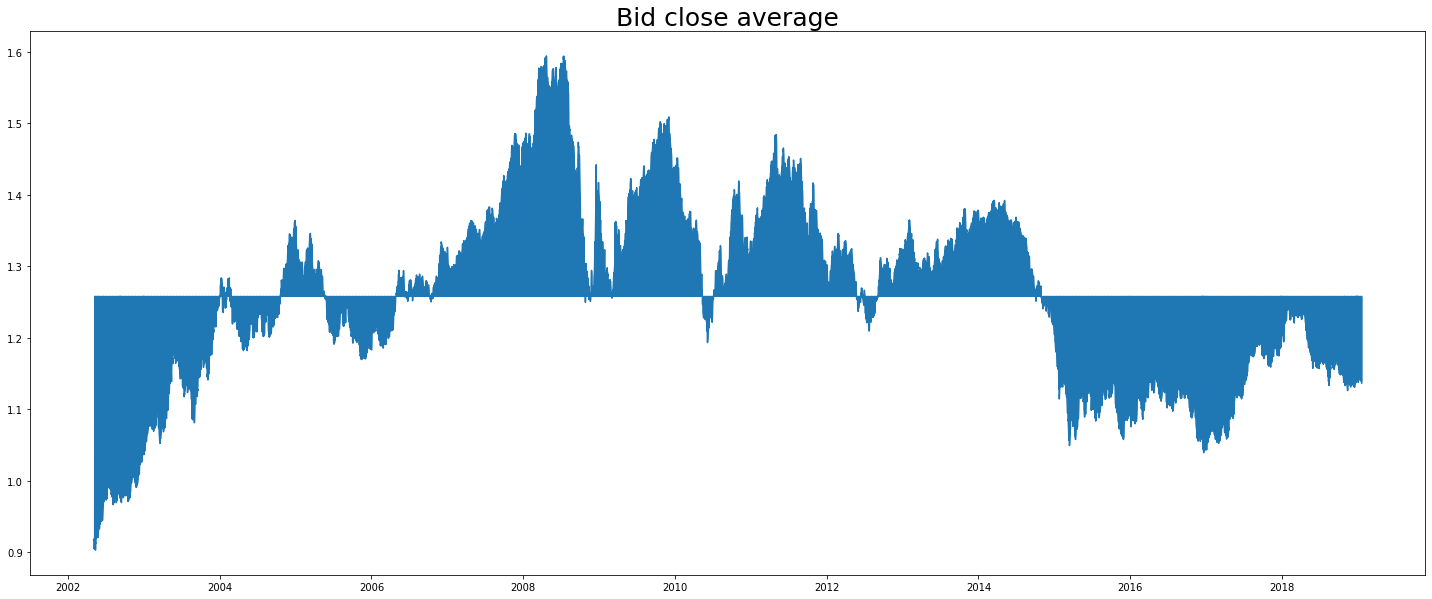

In [ ]:
dates = data.index.values
bid_close  = data['BidClose'].values
  
plt.figure(figsize=(25,10))
plt.plot(dates, bid_close)
plt.title('Bid close average',
          fontsize=25);

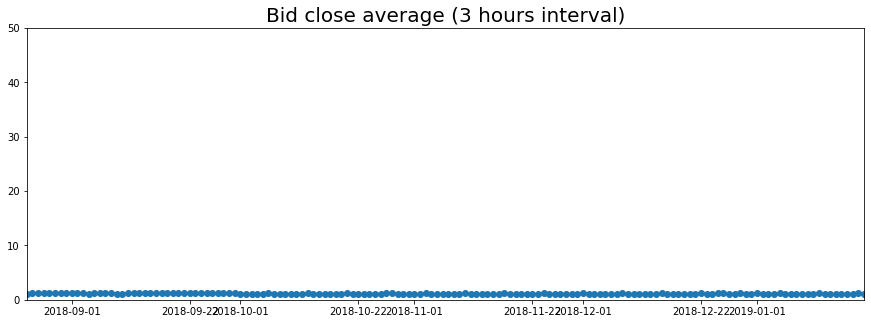

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(dates, bid_close, 'o-')
plt.title('Bid close average (3 hours interval)', fontsize=20)
plt.axis([dates[-150],dates[-1],0,50]);

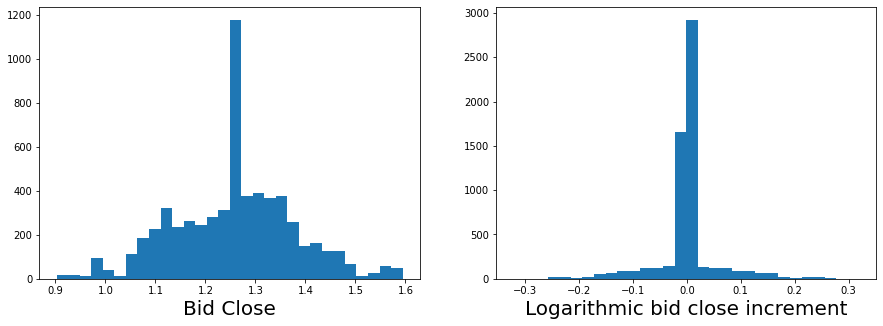

Bid close average                      : 1.2577921310904654
Logarithmic bid close increment average: 3.51932007424842e-05


In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(bid_close, bins=30)
plt.xlabel('Bid Close', fontsize=20)
plt.subplot(1,2,2)
aux = np.log( bid_close[1:] / bid_close[0:-1]  )
plt.hist(aux, bins=30)
plt.xlabel('Logarithmic bid close increment', fontsize=20)
plt.show()
print("Bid close average                      :", bid_close.mean())
print("Logarithmic bid close increment average:", aux.mean())

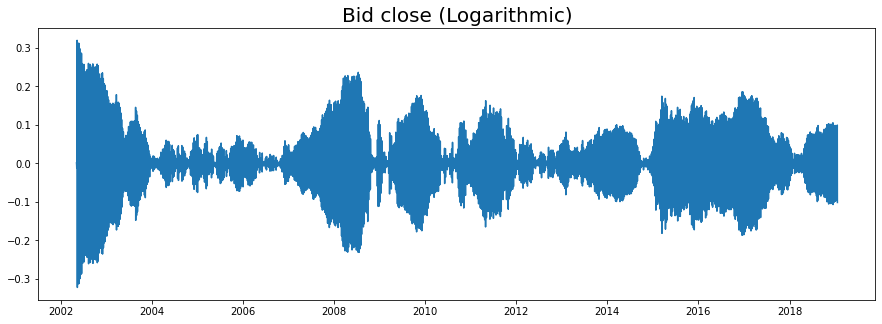

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(dates[1:], aux)
plt.title('Bid close (Logarithmic)',
          fontsize=20);

In [ ]:
eps = 1e-11

NAN = np.NAN

# Logarithmic transformation

def transform_logratios(serie):
    aux = np.log((serie[1:]+eps) / (serie[0:-1]+eps))
    return np.hstack( ([NAN], aux))
def inverse_transform_logratios(log_ratio, temp_prev):
    return np.multiply(temp_prev, np.exp(log_ratio))

In [ ]:
transform = transform_logratios
inverse_transform = inverse_transform_logratios

In [ ]:
# normalization
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.loc[:, ["BidOpen","BidHigh","BidLow", "BidChange", "AskOpen", "AskHigh", "AskLow", "AskClose", "AskChange"]])

In [ ]:
scaled_data = pd.DataFrame(scaled_data, columns = ["BidOpen","BidHigh","BidLow", "BidChange", "AskOpen", "AskHigh", "AskLow", "AskClose", "AskChange"])
scaled_data.index = data.index
scaled_data['BidClose'] = data['BidClose']
scaled_data

,BidOpen,BidHigh,BidLow,BidChange,AskOpen,AskHigh,AskLow,AskClose,AskChange,BidClose
datetime,,,,,,,,,,
2002-05-05,0.020528,0.020485,0.020583,0.482344,0.021518,0.021482,0.021576,0.021544,0.442702,0.916800
2002-05-06,0.022408,0.022361,0.022467,0.482344,0.022385,0.022347,0.022445,0.022411,0.442702,0.918100
2002-05-07,0.018215,0.018177,0.018264,0.482344,0.018197,0.018166,0.018245,0.018218,0.442702,0.915200
2002-05-08,0.002313,0.002308,0.002319,0.482344,0.002311,0.002307,0.002317,0.002313,0.442702,0.904200
2002-05-09,0.009541,0.009521,0.009567,0.482344,0.009532,0.009516,0.009557,0.009543,0.442702,0.909200
...,...,...,...,...,...,...,...,...,...,...
2019-01-16,0.343173,0.343484,0.343222,0.494733,0.342608,0.343071,0.342674,0.342903,0.455298,1.139913
2019-01-17,0.341779,0.341844,0.341821,0.487792,0.341211,0.341433,0.341288,0.341560,0.448683,1.138987
2019-01-18,0.341193,0.341128,0.341285,0.508968,0.340612,0.340712,0.340747,0.340835,0.463351,1.138464


In [ ]:
# splitting the data to train and test set

train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train, test = scaled_data.iloc[0:train_size], scaled_data.iloc[train_size:len(scaled_data)]
print(len(train), len(test))

4884 1221


In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
time_steps = 10

# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train['BidClose'], time_steps)
X_test, y_test = create_dataset(test, test['BidClose'], time_steps)
print(X_train.shape, y_train.shape)

(4874, 10, 10) (4874,)


In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
# for vizualisation loss and accuracy
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('mae')
    ax[1].plot(history.epoch, history.history["mae"], label="Train mae")
    ax[1].plot(history.epoch, history.history["val_mae"], label="Validation mae")
    ax[0].legend()
    ax[1].legend()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler
# Callbacks
best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    write_graph=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=40,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
# history = model.fit(train_set,epochs=15)


history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
    callbacks=callbacks
)

Epoch 1/15
  1/275 [..............................] - ETA: 0s - loss: 0.4293 - mae: 0.9211WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
272/275 [============================>.] - ETA: 0s - loss: 0.1526 - mae: 0.4341
Epoch 00001: val_loss improved from inf to 0.00223, saving model to ./base.model
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./base.model/assets
275/275 [==============================] - 13s 47ms/step - loss: 0.1514 - mae: 0.4313 - val_loss: 0.0022 - val_mae: 0.0585
Epoch 2/15
273/275 [============================>.] - ETA: 

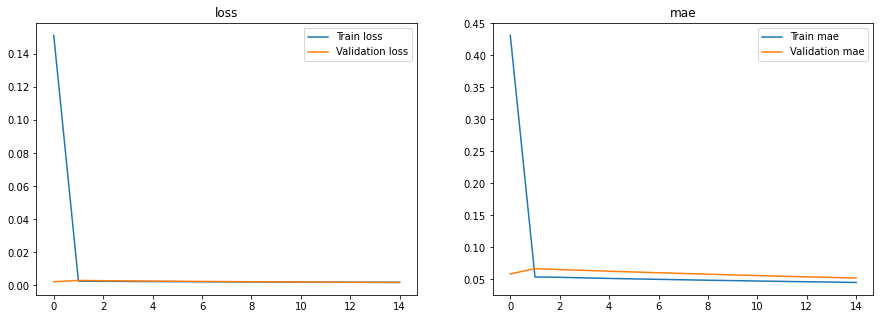

In [ ]:
show_final_history(history)
model_json = model.to_json()

In [ ]:
y_pred = model.predict(X_test)